# Traffic Signs Classification using CNN
Traffic Sign Classification Using Convolutional Neural Networks(CNNs), Which is widely used in various applications in the field of Artificial Intelligence. This notebook focuses on developing a deep learning model in order to classify the traffic signs.🛑❌🚫🚷🚳


## Project Steps:
> * #### Importing necessary Libraries
> * #### Data analysis
> * #### Reading Images Data
> * #### ResNet50 Model Building
> * #### Evaluation

---

### Importing necessary Libraries

In [38]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os

IMG_SIZE = 32
BATCH = 73139
EPOCHS = 50
SEED = 42
random.seed(42)

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import plot_model
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

---
### Data Analysis

In [2]:
path = '/kaggle/input/traffic-signs-classification'
lab = pd.read_csv('/kaggle/input/traffic-signs-classification/labels.csv')

In [3]:
lab.head()

ClassId                  Name
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)

In [4]:
lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ClassId  43 non-null     int64 
 1   Name     43 non-null     object
dtypes: int64(1), object(1)
memory usage: 816.0+ bytes


### Visualizing countplot of the classes

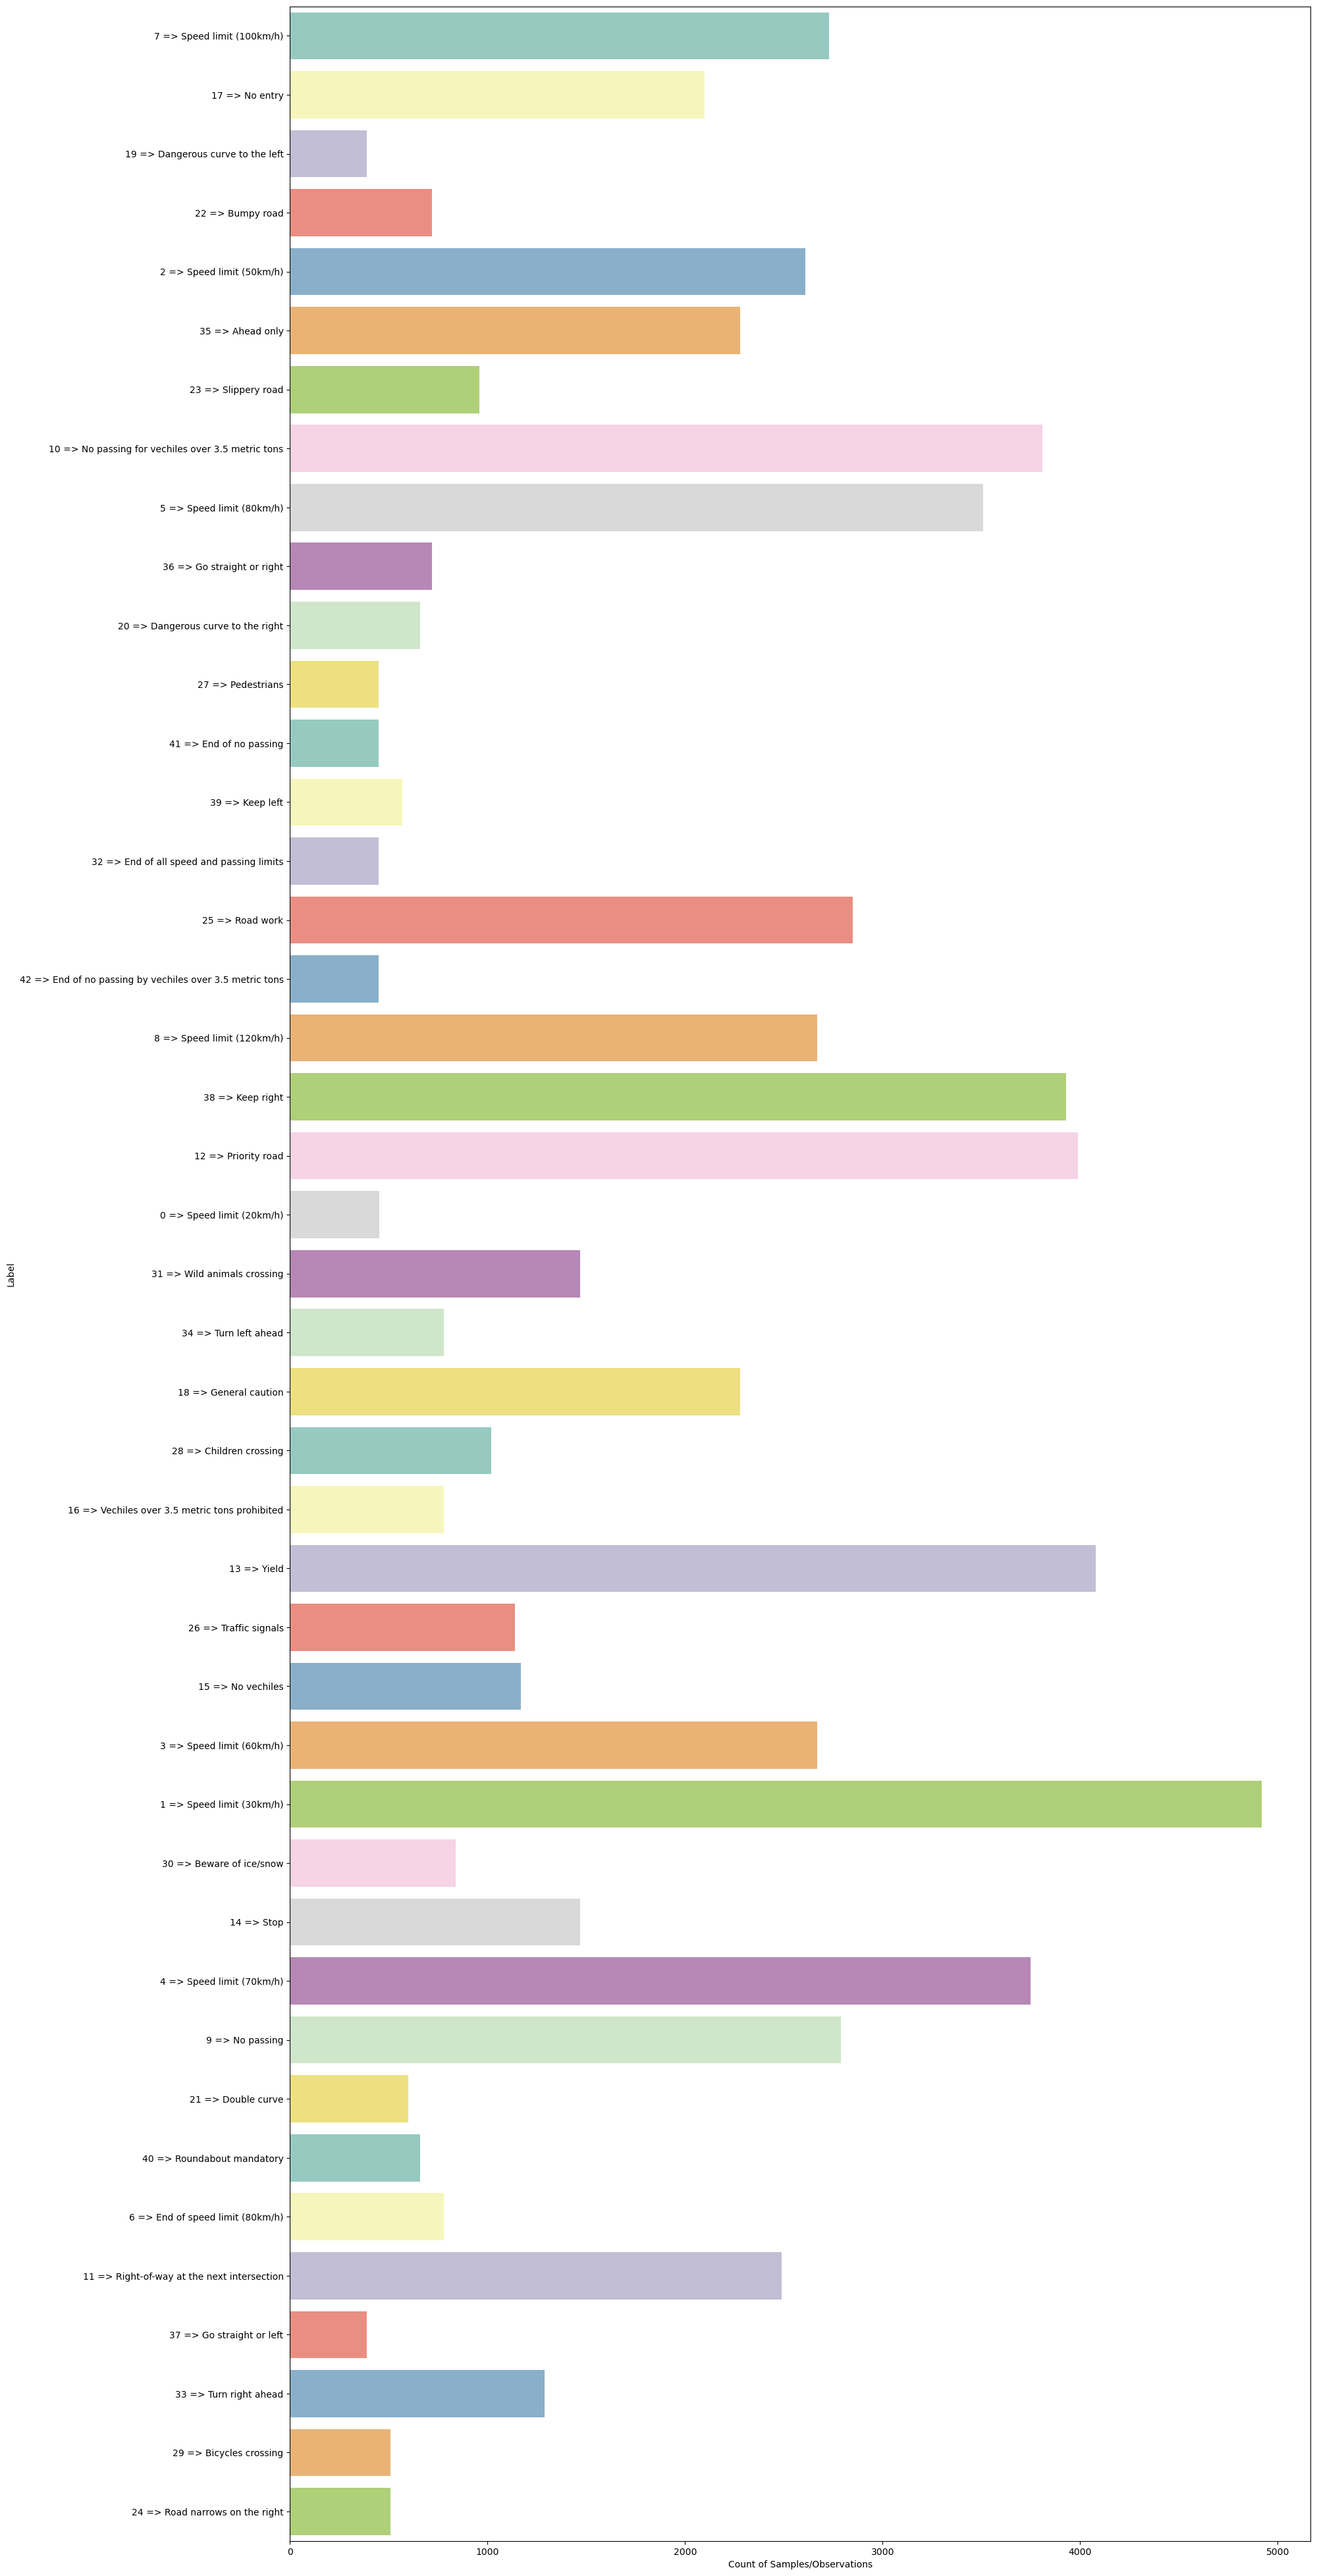

In [5]:
# Count PLot of the samples/observations w.r.t the classes
d = dict()
class_labels = dict()
for dirs in os.listdir(path + '/myData'):
    count = len(os.listdir(path+'/myData/'+dirs))
    d[dirs+' => '+lab[lab.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]

plt.figure(figsize = (20, 50))
sns.barplot(y = list(d.keys()), x = list(d.values()), palette = 'Set3')
plt.ylabel('Label')
plt.xlabel('Count of Samples/Observations');

### Reading Image Data

In [6]:
nb_classes = len(class_labels.keys())

datagen = ImageDataGenerator()
data = datagen.flow_from_directory('/kaggle/input/traffic-signs-classification/myData',
                                  target_size=(IMG_SIZE, IMG_SIZE),
                                  batch_size=BATCH,
                                  class_mode='categorical',
                                  shuffle=True)

Found 73139 images belonging to 43 classes.


In [7]:
X , y = data.next()

In [8]:
# Labels are one hot encoded
print(f"Data Shape   :{X.shape}\nLabels shape :{y.shape}")

Data Shape   :(73139, 32, 32, 3)
Labels shape :(73139, 43)


### Sample Images of Dataset


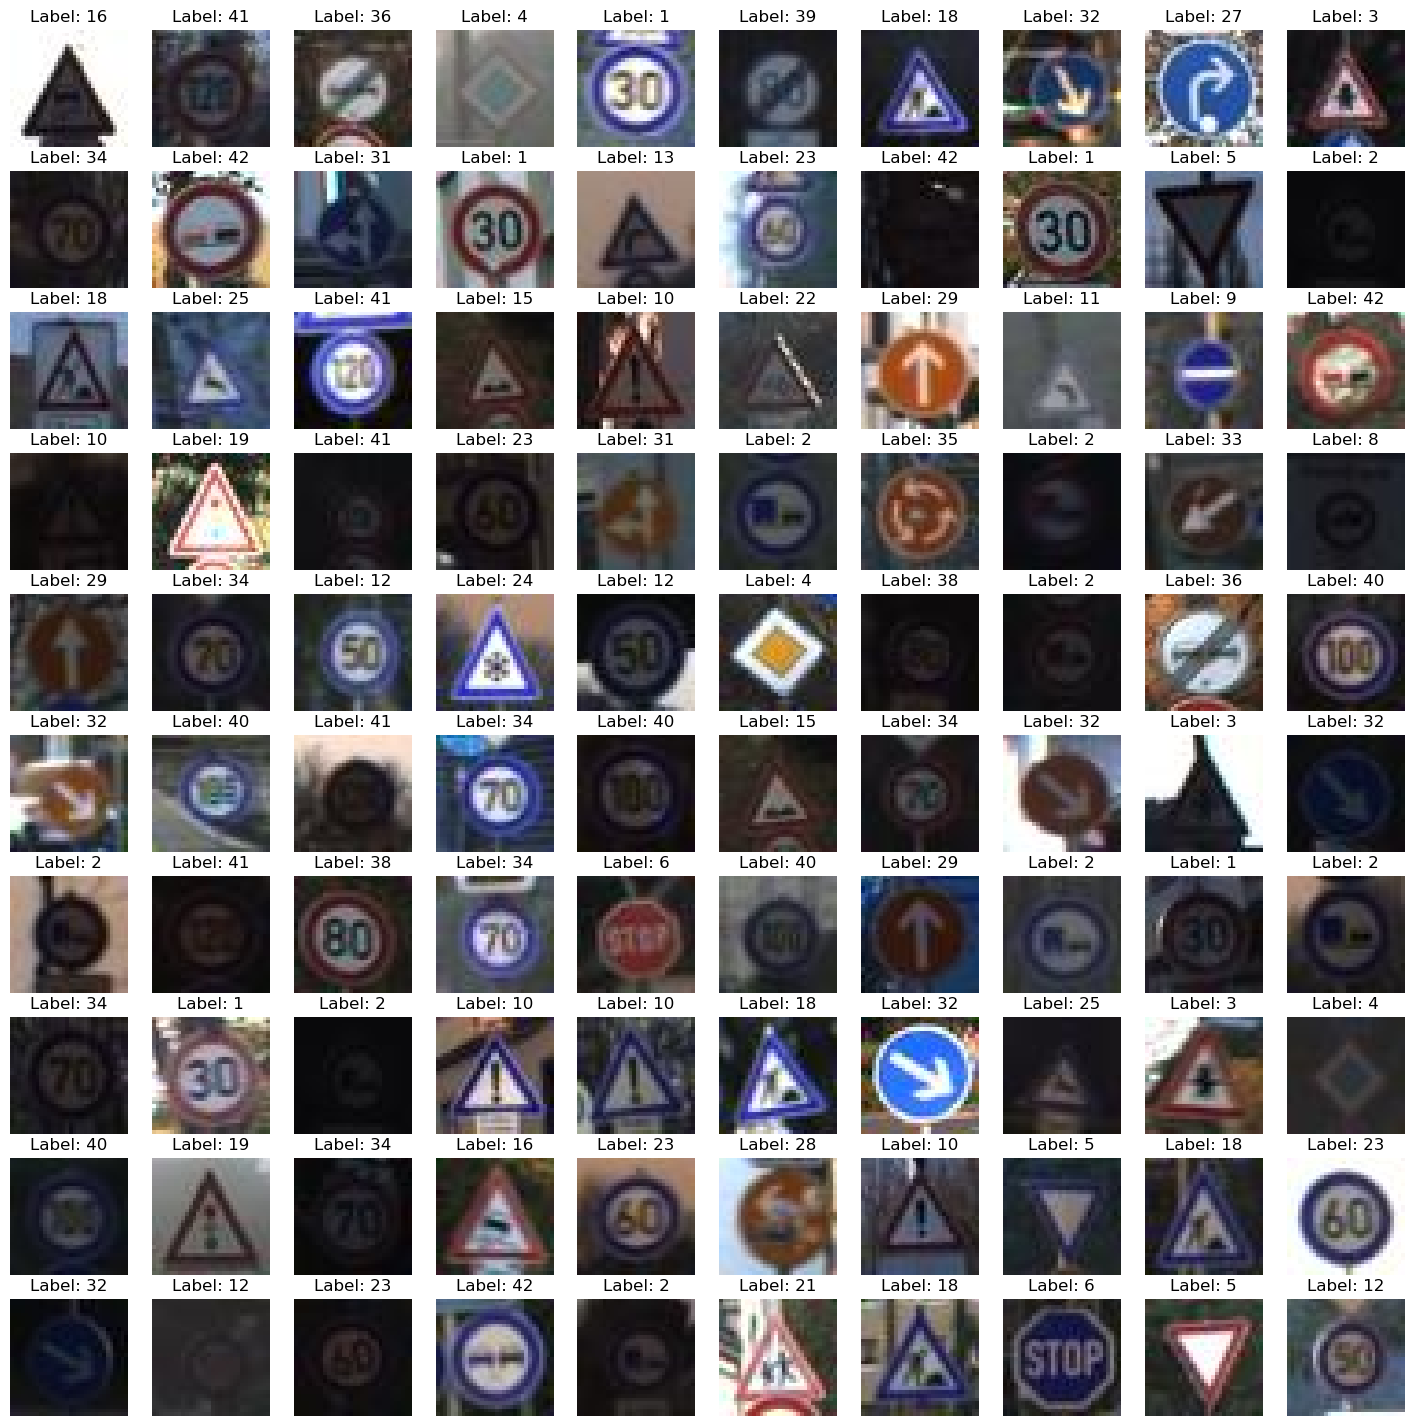

In [9]:
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r])))

**Dividing data into train and test in the split percentage of 80:20**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (58511, 32, 32, 3)
Test Shape : (14628, 32, 32, 3)


### Creating Callbacks


In [11]:
model_check = ModelCheckpoint('best_model.h5',
                              monitor='val_accuracy',
                              verbose=0,
                              save_best_only=True,
                              mode='max')

early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=5,
                      verbose=0,
                      mode='max',
                      restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=0.001)

csv_logger = CSVLogger('train_log.csv', separator=',')

## ResNet50

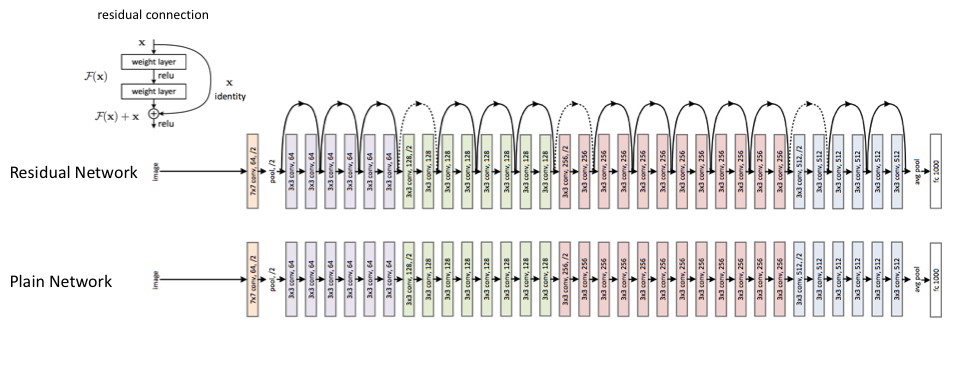

`ResNet-50 (Residual Networks)` is a deep neural network that is used as a backbone for many computer vision applications like `object detection`, `image segmentation`, etc. ResNet was created by the four researchers `Kaiming He`, `Xiangyu Zhang`, `Shaoqing Ren`, `Jian Sun` and it was the winner of the ImageNet challenge in 2015 with an error rate of 3.57%. It also addressed the problem of vanishing gradient that was common in very deep neural networks like itself.

## Customising ResNet50 model


In [12]:
resnet = ResNet50(weights= None, include_top=False, input_shape= (IMG_SIZE,IMG_SIZE,3))

In [13]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

### Visualising Model Architecture


In [14]:
RESNET_PLOT = plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)
RESNET_PLOT

### Compiling the Model


In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Fitting Model with Data


In [18]:
history =  model.fit(X_train,
                     y_train,
                     batch_size = 32,
                     epochs = EPOCHS,
                     verbose = 1, 
                     validation_data = (X_test, y_test),
                     callbacks = [model_check, early, reduce_lr, csv_logger])

Epoch 1/50
1829/1829 [==============================] - 108s 45ms/step - loss: 3.5283 - accuracy: 0.2915 - val_loss: 2.0632 - val_accuracy: 0.5712 - lr: 0.0010
Epoch 2/50
1829/1829 [==============================] - 79s 43ms/step - loss: 2.5292 - accuracy: 0.4698 - val_loss: 1.7319 - val_accuracy: 0.6371 - lr: 0.0010
Epoch 3/50
1829/1829 [==============================] - 82s 45ms/step - loss: 1.6862 - accuracy: 0.6342 - val_loss: 1.7733 - val_accuracy: 0.7186 - lr: 0.0010
Epoch 4/50
1829/1829 [==============================] - 81s 44ms/step - loss: 0.8966 - accuracy: 0.7542 - val_loss: 0.3451 - val_accuracy: 0.8845 - lr: 0.0010
Epoch 5/50
1829/1829 [==============================] - 77s 42ms/step - loss: 0.7135 - accuracy: 0.8190 - val_loss: 0.4510 - val_accuracy: 0.8553 - lr: 0.0010
Epoch 6/50
1829/1829 [==============================] - 78s 43ms/step - loss: 0.3879 - accuracy: 0.8941 - val_loss: 0.1181 - val_accuracy: 0.9607 - lr: 0.0010
Epoch 7/50
1829/1829 [=======================

In [19]:
# Saving the model
model.save('ResNet50_model.h5')

In [20]:
loss, acc = model.evaluate(X_test, y_test)
print('Accuracy: ', acc, '\nLoss    : ', loss)

458/458 [==============================] - 5s 11ms/step - loss: 0.0211 - accuracy: 0.9939
Accuracy:  0.9939157962799072 
Loss    :  0.021113963797688484


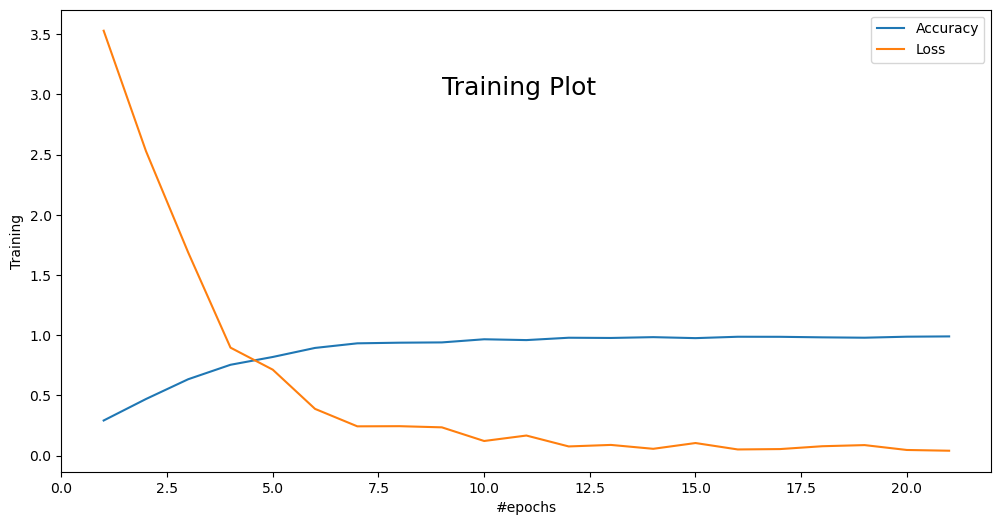

In [44]:
q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
plt.text(9, 3, 'Training Plot', fontsize=18, color='black')
plt.xlabel('#epochs')
plt.ylabel('Training')
plt.legend();
plt.savefig('line_Training_plot.png')

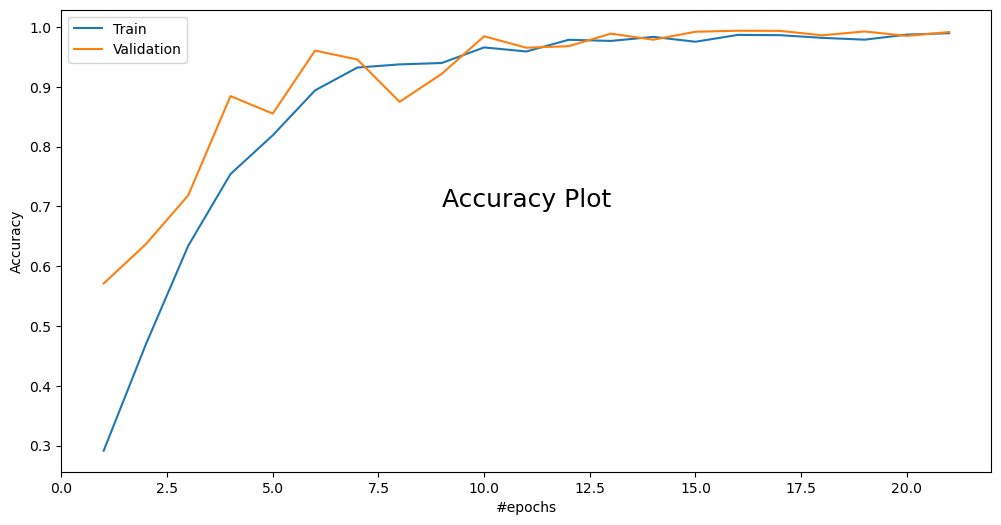

In [45]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_accuracy'], label = 'Validation')
plt.text(9, 0.7, 'Accuracy Plot', fontsize=18, color='black')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.legend();
plt.savefig('line_Accuracy_plot.png')

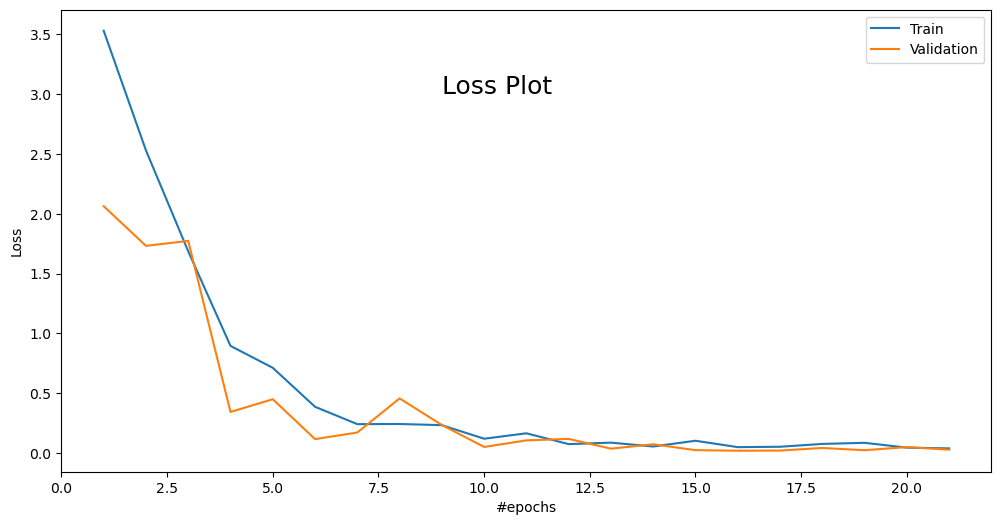

In [46]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_loss'], label = 'Validation')
plt.text(9, 3, 'Loss Plot', fontsize=18, color='black')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend();
plt.savefig('line_Loss_plot.png')

## Predict class labels of the test data


In [24]:
%%time
pred = np.argmax(model.predict(X_test), axis = 1)

458/458 [==============================] - 6s 10ms/step
CPU times: user 6.79 s, sys: 448 ms, total: 7.24 s
Wall time: 12.4 s


### Classification Report

In [39]:
labels = [class_labels[i] for i in range(43)]
print(classification_report(np.argmax(y_test, axis = 1), pred, target_names = labels))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      0.99      0.99        84
                              Speed limit (30km/h)       1.00      0.99      1.00       973
                              Speed limit (50km/h)       1.00      1.00      1.00       781
                              Speed limit (60km/h)       0.99      1.00      1.00       500
                              Speed limit (70km/h)       1.00      1.00      1.00       797
                              Speed limit (80km/h)       1.00      1.00      1.00       829
                       End of speed limit (80km/h)       1.00      0.99      1.00       302
                             Speed limit (100km/h)       1.00      1.00      1.00       212
                             Speed limit (120km/h)       1.00      0.99      1.00       163
                                        No passing       1.00      1.00      1.

### Confusion Matrix


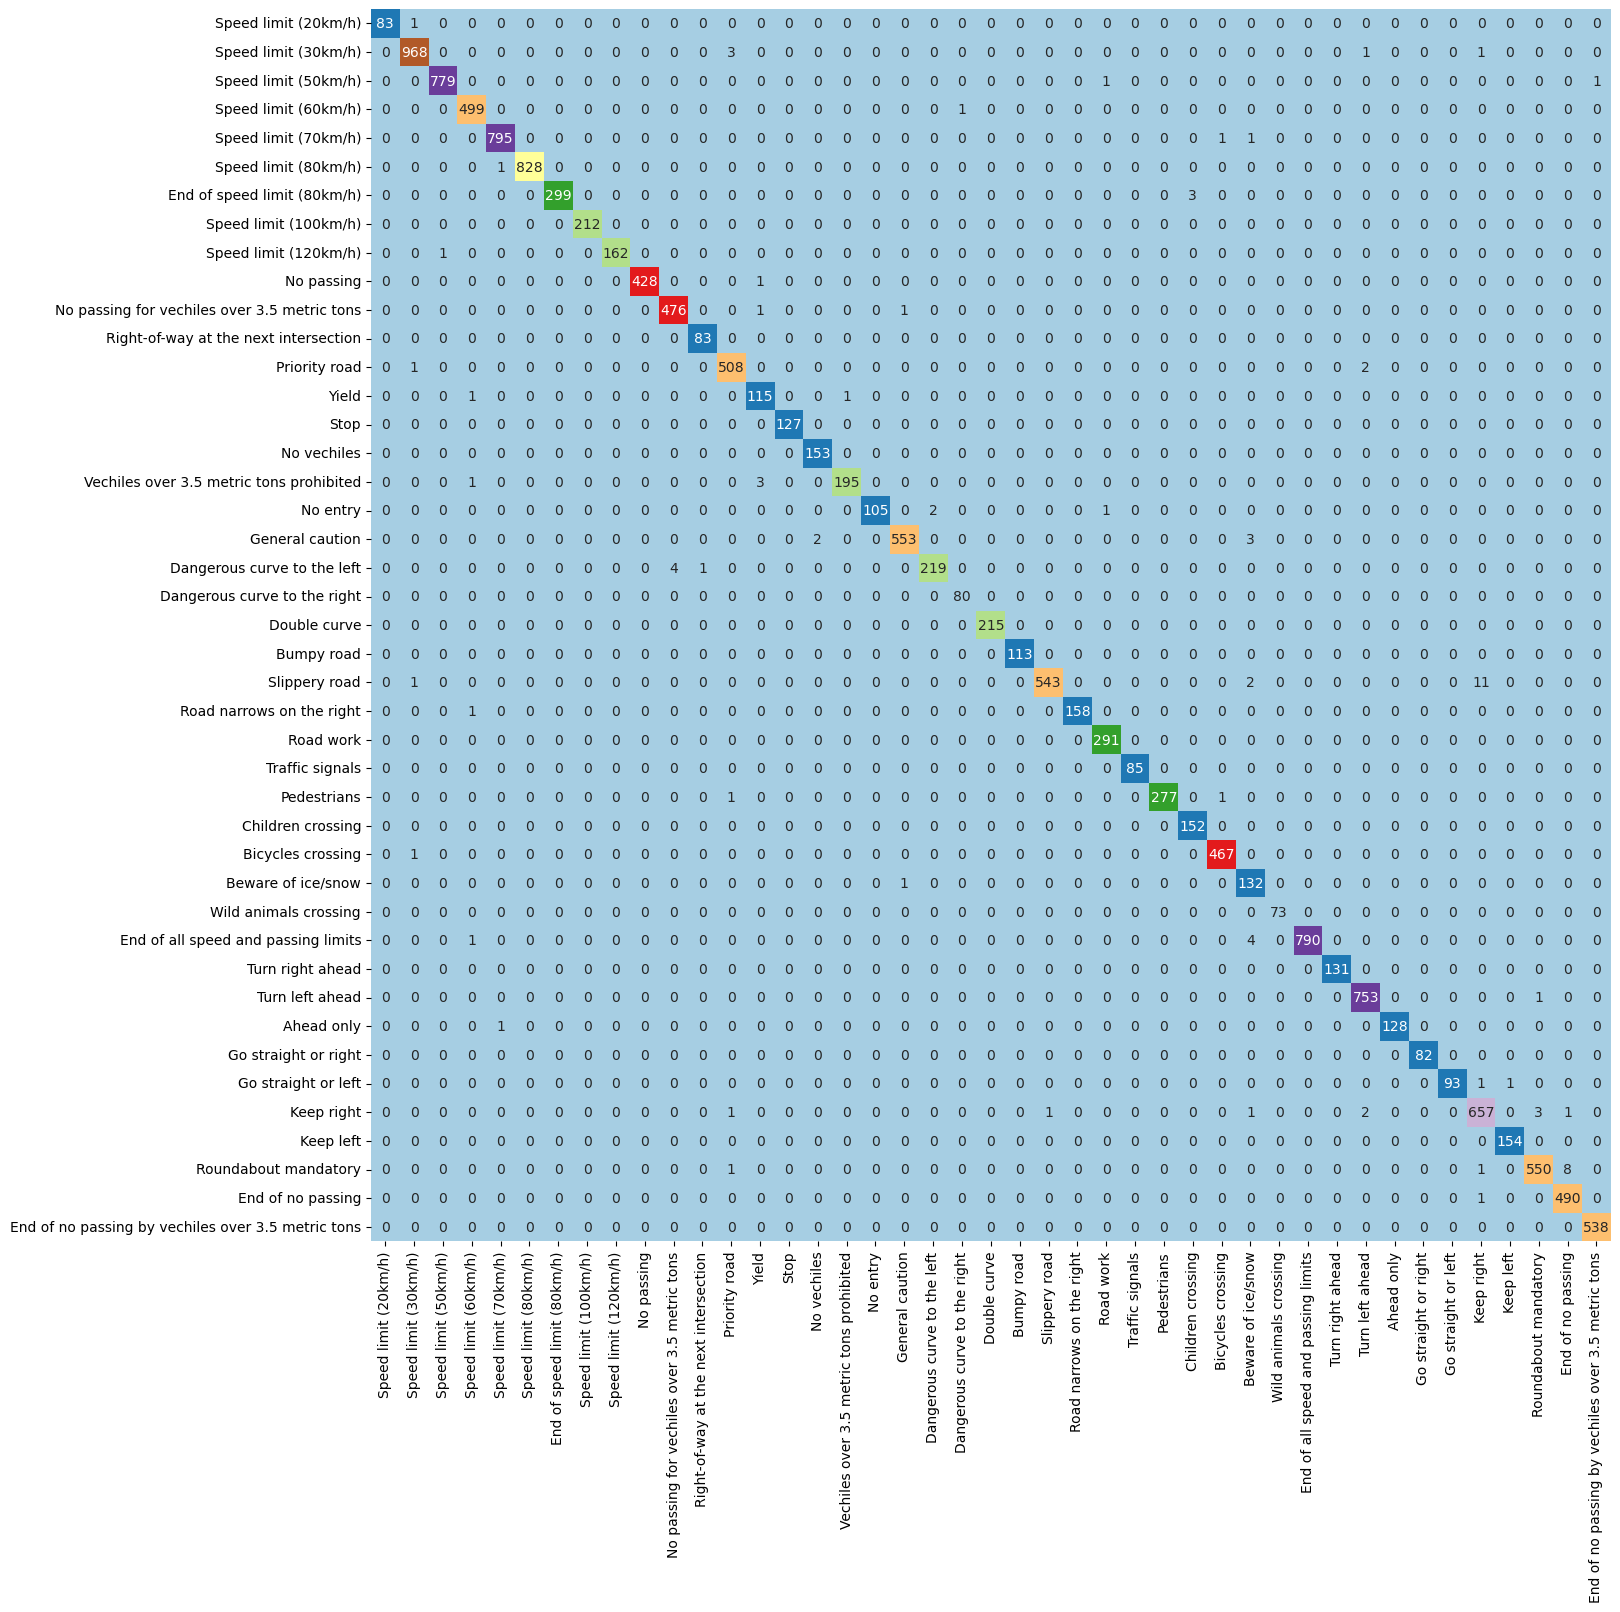

In [47]:
cmat = confusion_matrix(np.argmax(y_test, axis=1), pred)
plt.figure(figsize=(16,16))
sns.heatmap(cmat,
            annot = True,
            cbar = False,
            cmap='Paired',
            fmt="d",
            xticklabels=labels,
            yticklabels=labels);
plt.savefig('cm_plot.png')

## Classwise Accuracy


In [41]:
classwise_acc = cmat.diagonal()/cmat.sum(axis=1) * 100 
cls_acc = pd.DataFrame({'Class_Label':[class_labels[i] for i in range(43)], 'Accuracy': classwise_acc.tolist()}, columns = ['Class_Label', 'Accuracy'])
cls_acc.style.format({"Accuracy": "{:,.2f}",}).hide_index().bar(subset=["Accuracy"], color='tomato')

## Finally, Lets see the predictions of unseen data

1/1 [==============================] - 0s 23ms/step


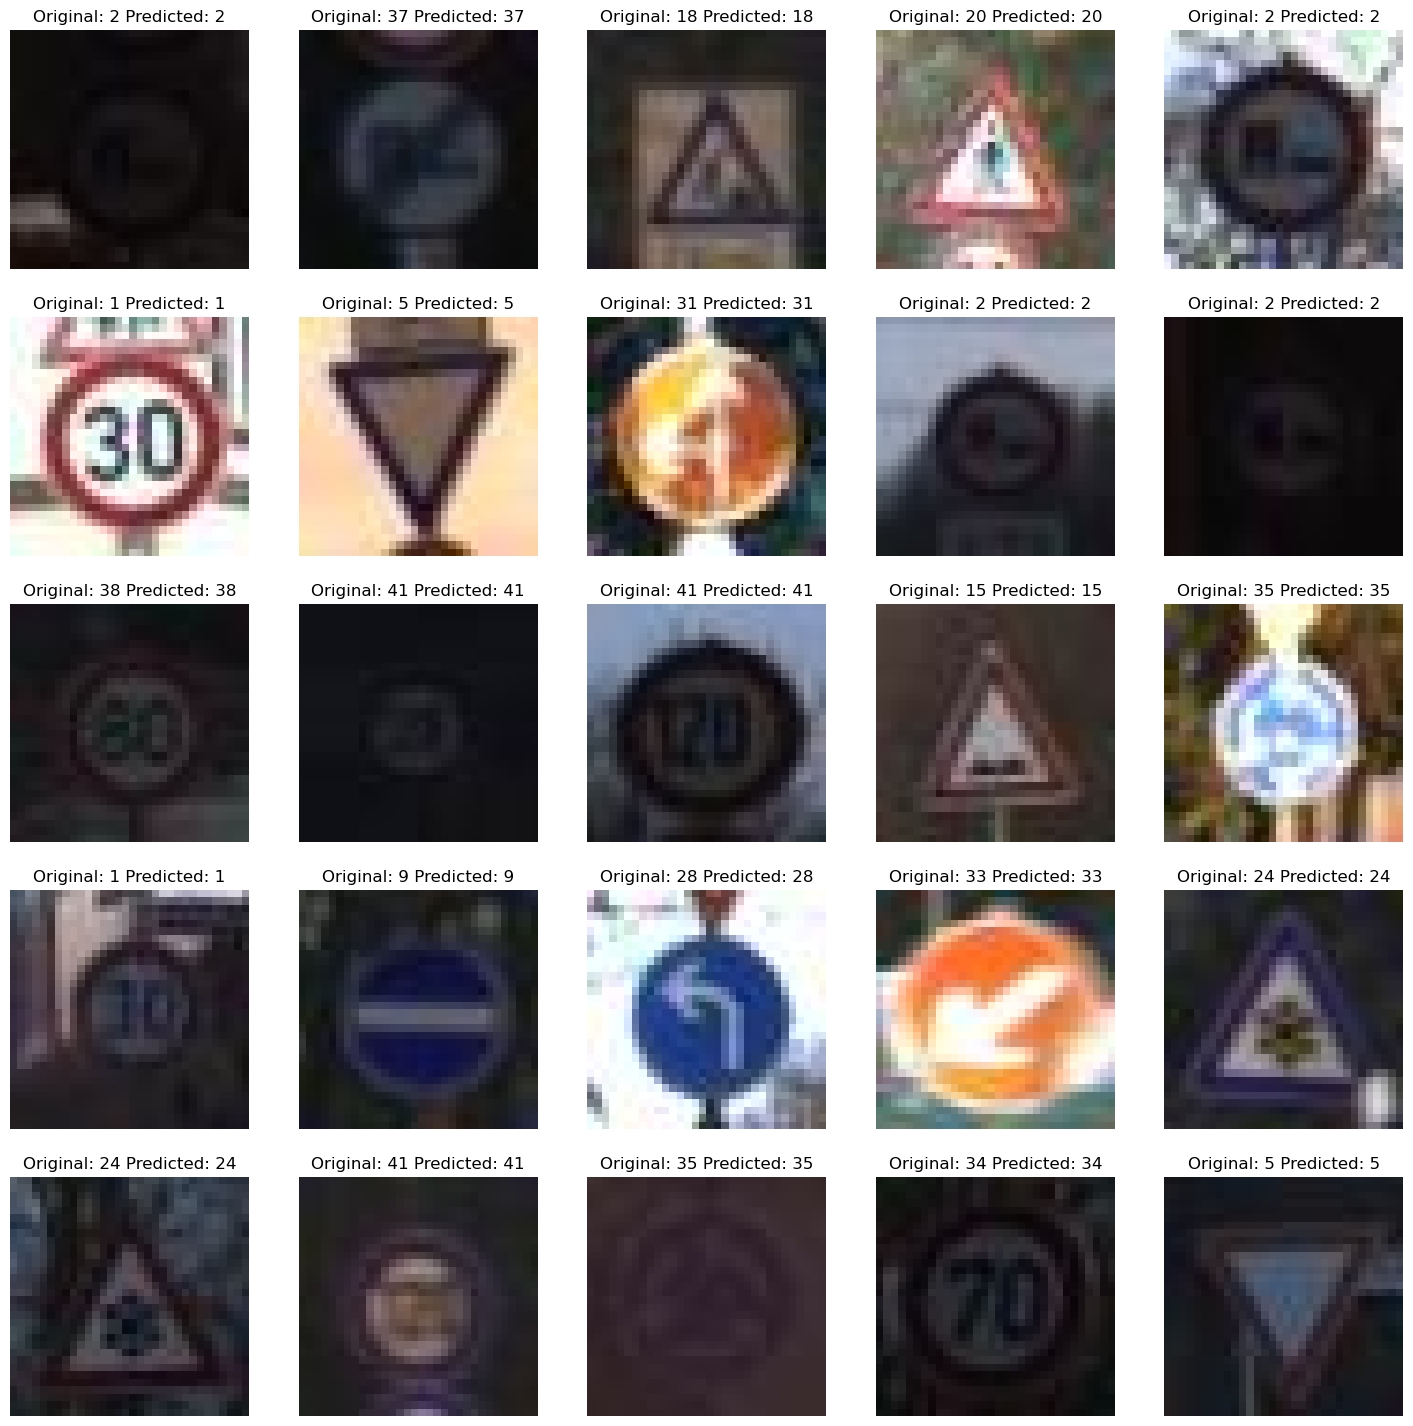

In [42]:
fig, axes = plt.subplots(5,5, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(y_test[r]), np.argmax(model.predict(X_test[r].reshape(1, 32, 32, 3)))))